In [4]:
# possibly required libraries
import numpy as np
import matplotlib.pyplot as plt
import time as time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import ToTensor,Lambda
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [5]:
# load data
import os
data_dir = 'imagesoasis\Data'# change to data path
# labels = os.listdir(data_dir)
labels = ['Mild Dementia',
 'Very mild Dementia',
 'Moderate Dementia',
 'Non Demented']

transforms_list = transforms.Compose([transforms.Grayscale(),
                                      transforms.ToTensor()
                                      ])
dataset = ImageFolder(data_dir, transforms_list, target_transform=Lambda(lambda y: torch.zeros(4, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))




# Sthe random seed for reproducible datasets
random_seed = 42
torch.manual_seed(random_seed)

In [6]:
labels = ['Mild Dementia',
 'Very mild Dementia',
 'Moderate Dementia',
 'Non Demented']
for label in labels:
  print('number of {}: {}'.format(label, len(os.listdir(os.path.join(data_dir, label)))))

number of Mild Dementia: 5002
number of Very mild Dementia: 13725
number of Moderate Dementia: 488
number of Non Demented: 5919


In [7]:
# Split into training and testing set in the ratio of 0.7: 0.3

# fill your code:

train_size =0.7
test_size =0.3

train_set, test_set = random_split(dataset, [train_size, test_size])

In [8]:
# Split datasets into batches with batch size = 256
batch_size = 256
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size, num_workers=0, pin_memory=True)

In [9]:
# Define the model as required
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # activations:
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # layers
        self.fc1 = nn.Linear(123008, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 4)
      
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
      
def evaluate(model, test_loader, device):
    correct = 0
    total = 0

    y_pred = []
    y_true = []


    with torch.no_grad():
        for images, labels in test_loader:
            bs = images.shape[0]
            images = images.to(device).reshape((bs, -1))
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.argmax(axis = 1)).sum().item()

        y_pred.extend(predicted.tolist())
        y_true.extend(labels.argmax(axis = 1).tolist())
        return correct / total, y_pred, y_true


In [10]:
tic = time.time()
device = "cuda" if torch.cuda.is_available() else "cpu"
# fill your code here:

# Initialize the model
model = MLP().to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Training loop
num_epochs = 1

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    bs = images.shape[0]
    images = images.to(device).reshape((bs, -1))
    labels = labels.to(device)
     # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, labels)

    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
toc = time.time()
hours, rem = divmod(toc-tic, 3600)
minutes, seconds = divmod(rem, 60)
print("elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

elapsed time: 00:05:50.65


In [11]:
# report training and testing accuray:
acc, _, _ = evaluate(model, test_loader, device)
print('training acc {}'.format(acc))
acc, y_pred, y_true = evaluate(model, test_loader, device)
print('test acc {}'.format(acc))

training acc 0.5490716180371353
test acc 0.5490716180371353


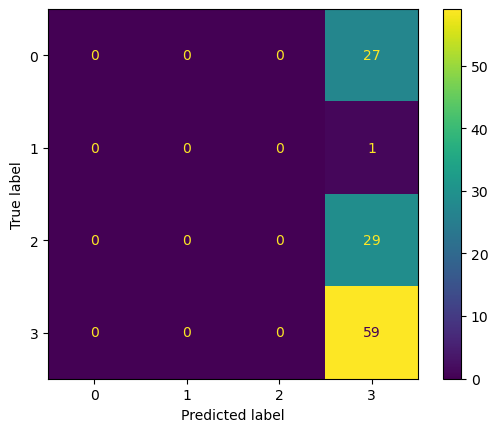

In [12]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [13]:
# display classification report
report = classification_report(y_true, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        29
           3       0.51      1.00      0.67        59

    accuracy                           0.51       116
   macro avg       0.13      0.25      0.17       116
weighted avg       0.26      0.51      0.34       116

